In [25]:
import json
import pandas as pd
import re
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from gensim.models import Doc2Vec, Word2Vec
from tqdm import tqdm
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import spacy
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from string import punctuation
from nltk import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import enchant
from sklearn.decomposition import PCA
from matplotlib import pyplot

# Load the lyrics in a pandas dataframe

In [2]:
with open('../data/top_hits_merged_clean_lyrics_audio_features.json') as json_file:
    top_hits = json.load(json_file)

In [3]:
with open('../data/not_hits_merged_clean_lyrics_audio_features.json') as json_file:
    not_hits = json.load(json_file)

In [4]:
top_hits_df = pd.read_json(top_hits)
not_hits_df = pd.read_json(not_hits)

In [5]:
top_hits_df['class'] = 1
not_hits_df['class'] = 0
df = pd.concat([top_hits_df, not_hits_df])
df.head()

,id,lyrics,source,clean_lyrics,acousticness,album,analysis_url,artists,available_markets,danceability,...,time_signature,track,track_href,track_number,type,uri,valence,year,decade,class
0,1rfofaqEpACxVEHIZBJe6W,"[[Intro: Pharrell Williams], \nHey, \n, \n[Cho...",genius.com,hey half of my heart is in havana ooh na na h...,0.18400,"{'album_type': 'album', 'artists': [{'external...",https://api.spotify.com/v1/audio-analysis/1rfo...,[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",0.765,...,4,True,https://api.spotify.com/v1/tracks/1rfofaqEpACx...,4,audio_features,spotify:track:1rfofaqEpACxVEHIZBJe6W,0.394,2018,2010,1
1,7mldq42yDuxiUNn08nvzHO,"[[Verse 1], \n, Got a girl from the south side...",genius.com,got a girl from the south side got braids in ...,0.46300,"{'album_type': 'single', 'artists': [{'externa...",https://api.spotify.com/v1/audio-analysis/7mld...,[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",0.731,...,4,True,https://api.spotify.com/v1/tracks/7mldq42yDuxi...,1,audio_features,spotify:track:7mldq42yDuxiUNn08nvzHO,0.631,2017,2010,1
10,50kpGaPAhYJ3sGmk6vplg0,"[[Produced by Benny Blanco], \n, \n[Verse 1], ...",genius.com,for all the times that you rained on my parad...,0.85600,"{'album_type': 'album', 'artists': [{'external...",https://api.spotify.com/v1/audio-analysis/50kp...,[{'external_urls': {'spotify': 'https://open.s...,"[AD, AR, AT, AU, BE, BG, BO, BR, CA, CH, CL, C...",0.607,...,4,True,https://api.spotify.com/v1/tracks/50kpGaPAhYJ3...,5,audio_features,spotify:track:50kpGaPAhYJ3sGmk6vplg0,0.545,2015,2010,1
100,0AKAxdNkwq9ZxRdW1DN9zW,"[[Verse 1], \nSeems like just yesterday, \nYou...",genius.com,seems like just yesterday you were a part of ...,0.00165,"{'album_type': 'album', 'artists': [{'external...",https://api.spotify.com/v1/audio-analysis/0AKA...,[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",0.548,...,4,True,https://api.spotify.com/v1/tracks/0AKAxdNkwq9Z...,3,audio_features,spotify:track:0AKAxdNkwq9ZxRdW1DN9zW,0.425,2004,2000,1
1000,3creXOuPJsbZgHYqnTdwHA,"[We're so sorry Uncle Albert, \nWe're so sorry...",songlyrics.com,we are so sorry uncle albert we are so sorry i...,0.47800,"{'album_type': 'album', 'artists': [{'external...",https://api.spotify.com/v1/audio-analysis/3cre...,[{'external_urls': {'spotify': 'https://open.s...,[],0.398,...,4,True,https://api.spotify.com/v1/tracks/3creXOuPJsbZ...,5,audio_features,spotify:track:3creXOuPJsbZgHYqnTdwHA,0.560,1971,1970,1


In [6]:
df.shape

(5396, 39)

In [7]:
df.columns

Index(['id', 'lyrics', 'source', 'clean_lyrics', 'acousticness', 'album',
       'analysis_url', 'artists', 'available_markets', 'danceability',
       'disc_number', 'duration_ms', 'energy', 'episode', 'explicit',
       'external_ids', 'external_urls', 'href', 'instrumentalness', 'is_local',
       'key', 'liveness', 'loudness', 'mode', 'name', 'popularity',
       'preview_url', 'speechiness', 'tempo', 'time_signature', 'track',
       'track_href', 'track_number', 'type', 'uri', 'valence', 'year',
       'decade', 'class'],
      dtype='object')

In [8]:
lyrics = df['clean_lyrics']
lyrics.head()

0        hey half of my heart is in havana ooh na na h...
1        got a girl from the south side got braids in ...
10       for all the times that you rained on my parad...
100      seems like just yesterday you were a part of ...
1000    we are so sorry uncle albert we are so sorry i...
Name: clean_lyrics, dtype: object

# Count most popular words
#### The most frequent words are stopwords, unsurprisingly

In [9]:
stoplist = set(stopwords.words('english') + list(punctuation))
texts = lyrics.str.lower()
word_counts = Counter(word_tokenize('\n'.join(texts)))
word_counts.most_common(10)

[('i', 78939),
 ('you', 71486),
 ('the', 54307),
 ('to', 40639),
 ('and', 32937),
 ('it', 30981),
 ('a', 29301),
 ('me', 28941),
 ('not', 28059),
 ('is', 27515)]

#### We remove the stopwords and generate wordclouds showing the most popular words accross all lyrics. 

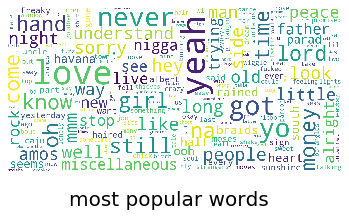

In [10]:
def show_wordcloud(texts, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stoplist,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=2
    ).generate(str(texts))
    
    fig = plt.figure(0, figsize=(6, 6))
    plt.axis('off')
    fig.suptitle(t="most popular words", fontsize=20)
    fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    

show_wordcloud(texts)

#### Here we generate wordclouds displaying the most popular words per decade

decade: 1970


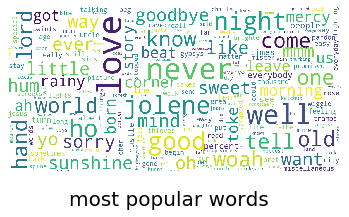

decade: 1980


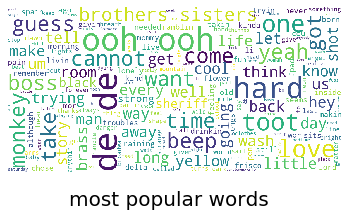

decade: 1990


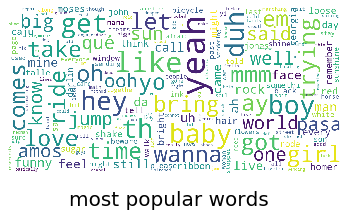

decade: 2000


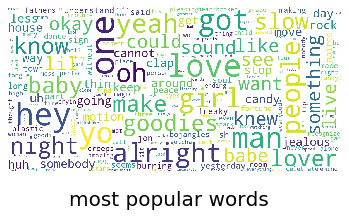

decade: 2010


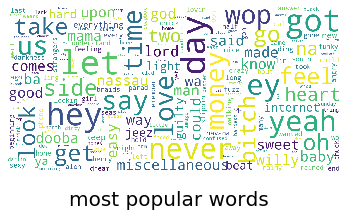

In [11]:
for i in range(1970, 2020, 10):
    print("decade: " + str(i))
    show_wordcloud(texts.loc[df['decade'] == i])

#### We can see that older songs contain more words such as "love", "sunshine", "world", whereas more recent songs contain more words such as "money", "b**tch", or "time". This could reveal some global change in our society, that express themselves naturally in the music. 

# Remove non-English words
#### We do the exact same thing here, but we remove all non-English words using the "enchant" library

In [12]:
d = enchant.Dict("en_US")
count = 0
for lyric in lyrics:
    for word in lyric:
        if d.check(word)==False:
            count += 1
            del word
print(count)
            

492


In [13]:
texts_non_eng = lyrics.str.lower()
word_counts = Counter(word_tokenize('\n'.join(texts)))
word_counts.most_common(10)

[('i', 78939),
 ('you', 71486),
 ('the', 54307),
 ('to', 40639),
 ('and', 32937),
 ('it', 30981),
 ('a', 29301),
 ('me', 28941),
 ('not', 28059),
 ('is', 27515)]

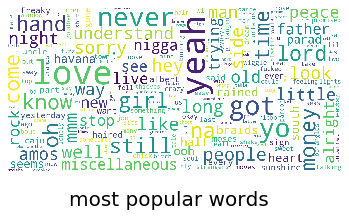

In [14]:
show_wordcloud(texts_non_eng)

decade: 1970


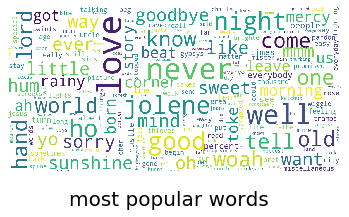

decade: 1980


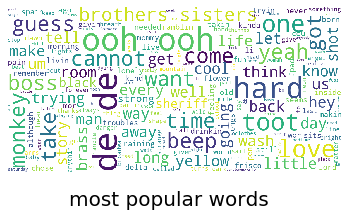

decade: 1990


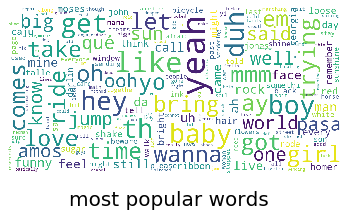

decade: 2000


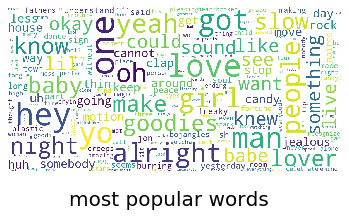

decade: 2010


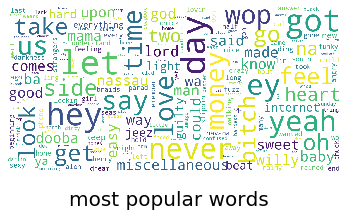

In [15]:
for i in range(1970, 2020, 10):
    print("decade: " + str(i))
    show_wordcloud(texts_non_eng.loc[df['decade'] == i])

#### The results are not much different from the preivous graphs because the non-English words were not frequent enough (roughly 500 words removed) in order to make a difference in the most frequent words in the lyrics. 

# Topic modeling

In [45]:
model = Word2Vec(texts)

In [46]:
words = list(model.wv.vocab)
print(words)

[' ', 'h', 'e', 'y', 'a', 'l', 'f', 'o', 'm', 'r', 't', 'i', 's', 'n', 'v', 'k', 'b', 'c', 'u', 'w', 'd', 'g', 'j', 'p', 'q', 'x', '1', '5', '3', '0', 'z', '4', '2', 'é', '9', '8', '7', '6', 'ñ', 'è', 'á', 'à', 'ó', 'ú', 'í', 'â', 'а', 'р', 'и', 'к', 'с', 'п', 'о', '_', 'ü', 'ã', 'ò', 'ì', 'ö']


/Users/Samuel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


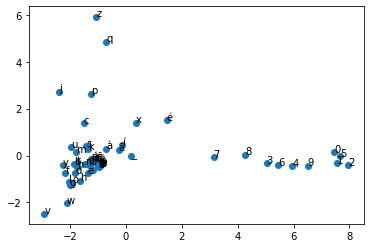

In [52]:
from gensim.models import Word2Vec
# define training data
sentences = texts
# train model
model = Word2Vec(sentences, min_count=5, workers=100)
# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()